# Examination of Coupled and Uncoupled MDOF Spring Mass Systems

## Shock Input

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_half_sine_shock(peak_g, pulse_width, sample_rate=10000, total_time=None):
    """
    Generate a half-sine shock pulse for base motion acceleration input.
    
    Parameters:
    peak_g (float): Peak acceleration in G's
    pulse_width (float): Pulse width in seconds
    sample_rate (int): Sampling rate in Hz
    total_time (float): Total time duration in seconds (default: 4 * pulse_width)
    
    Returns:
    tuple: (time_array, acceleration_array) in seconds and m/s²
    """
    g = 9.81  # gravitational acceleration in m/s²
    
    if total_time is None:
        total_time = 4 * pulse_width  # Default to 4 times pulse width
    
    # Create time array
    dt = 1 / sample_rate
    time = np.arange(0, total_time, dt)
    
    # Initialize acceleration array
    acceleration = np.zeros(len(time))
    
    # Find indices for the pulse duration
    pulse_indices = time <= pulse_width
    
    # Generate half-sine pulse
    t_pulse = time[pulse_indices]
    acceleration[pulse_indices] = peak_g * g * np.sin(np.pi * t_pulse / pulse_width)
    
    return time, acceleration

# Generate the shock input
peak_amplitude = 35  # G's
pulse_width = 0.050  # 50 milliseconds
sample_rate = 10000  # Hz

time, base_acceleration = generate_half_sine_shock(peak_amplitude, pulse_width, sample_rate)


### Shock Pulse Plot

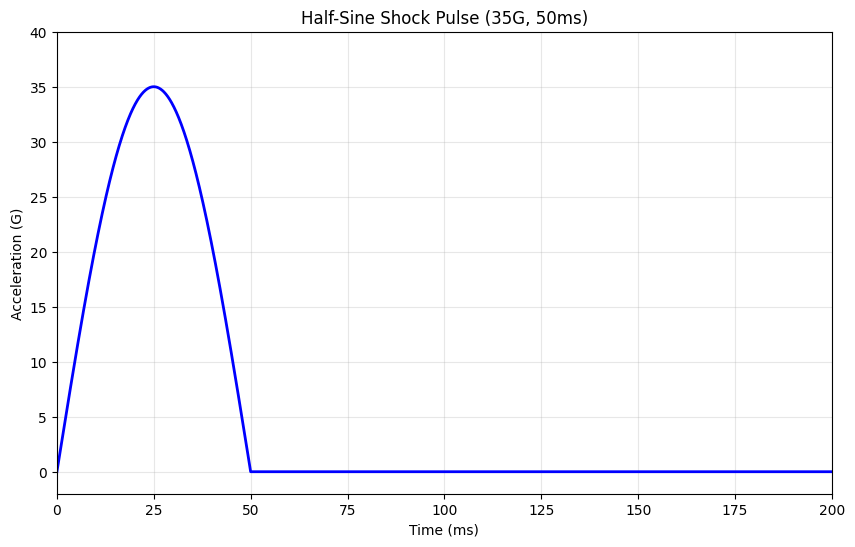

Peak acceleration: 35 G (343.4 m/s²)
Pulse width: 50.0 ms
Sample rate: 10000 Hz
Total duration: 0.200 s


In [2]:
# Plot the shock pulse
plt.figure(figsize=(10, 6))
plt.plot(time * 1000, base_acceleration / 9.81, 'b-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Acceleration (G)')
plt.title('Half-Sine Shock Pulse (35G, 50ms)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 200)  # Show first 200ms
plt.ylim(-2, 40)
plt.show()

print(f"Peak acceleration: {peak_amplitude} G ({peak_amplitude * 9.81:.1f} m/s²)")
print(f"Pulse width: {pulse_width * 1000} ms")
print(f"Sample rate: {sample_rate} Hz")
print(f"Total duration: {time[-1]:.3f} s")

### Shock Response Spectrum

In [3]:
import pyyeti
from pyyeti import srs

# Calculate the shock response spectrum
# Define frequency range from 1 Hz to 1000 Hz
freq_min = 1.0
freq_max = 1000.0
num_points = 100  # Number of frequency points

# Create logarithmically spaced frequency array
frequencies = np.logspace(np.log10(freq_min), np.log10(freq_max), num_points)

# Calculate time step
dt = time[1] - time[0]


In [1]:

# Calculate SRS using PyYeti
# Q = 10 is a typical damping ratio for shock response spectrum
Q = 10
#srs_accel = srs.srs(base_acceleration, dt, frequencies, Q=Q)
srs_accel = srs.srs(base_acceleration, dt, frequencies, Q=Q, makeplot=False)



NameError: name 'srs' is not defined

In [ ]:

# Plot the shock response spectrum
plt.figure(figsize=(12, 8))
plt.loglog(frequencies, srs_accel / 9.81, 'r-', linewidth=2, label=f'Q={Q}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Acceleration SRS (G)')
plt.title('Shock Response Spectrum - Half-Sine Pulse (35G, 50ms)')
plt.grid(True, which="both", alpha=0.3)
plt.xlim(freq_min, freq_max)
plt.legend()
plt.show()

# Print some key statistics
max_srs_g = np.max(srs_accel) / 9.81
max_srs_freq = frequencies[np.argmax(srs_accel)]

print(f"Input shock: {peak_amplitude}G, {pulse_width*1000}ms half-sine")
print(f"SRS Q factor: {Q}")
print(f"Maximum SRS: {max_srs_g:.1f}G at {max_srs_freq:.1f} Hz")
print(f"Amplification factor: {max_srs_g/peak_amplitude:.2f}")

## SDOF System

## 2-DOF System

## 3-DOF System